In [1]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
import zipfile
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras import backend as keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
from dataset_joiner import DatasetWorker, VocabularyWorker
from performance import PerformanceViewer, TrainingEval
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1234567890)

In [3]:
# import data
# specify the type of information which shall be extracted
#extraction_of = 'contexts'
extraction_of = 'sentiments'
#extraction_of = 'aspects'

#sentiment, aspect oder modifier -> diese drei braucht man
#extraktion von polarität nicht gefragt


# specify filenames in the next line
if extraction_of in ['contexts']:
    filename = r'data_laptop_ctxt.json'
elif extraction_of in ['sentiments','aspects']:
    filename = r'data_laptop_absa.json'

## in this example, we use the glove word embeddings as input for the neural network
## download glove.42B.300d.txt from http://nlp.stanford.edu/data/glove.42B.300d.zip
filename_embedding_zip = r'glove.42B.300d.zip' # folder of downloaded glove zip file
## specify folder where to store the glove embeddings
filepath_embedding = filename_embedding_zip.replace('.zip','')
## unzip and save glove to a folder manually or with the next lines
if not os.path.exists(filepath_embedding):
    with zipfile.ZipFile(filename_embedding_zip,"r") as zip_ref:
        zip_ref.extractall(filepath_embedding)
os.listdir(filepath_embedding)[0]
filename_embedding = filepath_embedding + '/' + os.listdir(filepath_embedding)[0]


with open(filename,'r', encoding='utf8') as infile:
    example_data = json.load(infile)


In [4]:
max_seq_length = 100
ds = DatasetWorker(example_data)
ds.applyPreprocessing()
# we let the nn use 20% of train data to validate and hold back 10% for final eval 
# (data the net does not see while training)
ds.setTrainTestSplitRatio(0.9)
#options for splitDataset = all_agree, one_agrees, every_review
ds.splitDataset("one_agrees")
ds.buildDatasetSequence(max_seq_length)
ds.describe()

tokenize dataset: 3101it [00:00, 150796.93it/s]
split dataset tokens: 3101it [00:00, 639330.35it/s]
split dataset labels: 3101it [00:00, 80179.37it/s]
update test labels: 100%|██████████| 311/311 [00:00<00:00, 641311.97it/s]

maunally set train test split ratio to 0.9
train test ratio 0.9
train data sentence count: 2790
test data sentence count: 311

train token count: 48153
test token count: 5539

train details: {'0': 40516, 'B_S': 4527, 'I_S': 3110}
test details: {'0': 4634, 'B_S': 484, 'I_S': 421}


In [5]:
#build vocab and add embedding
vw = VocabularyWorker()
vw.buildVocabulary(ds.dataset)
vw.buildEmbedding(ds.train_labels)

build labelclasses: 100%|██████████| 2790/2790 [00:00<00:00, 968396.90it/s]


In [6]:
# Convert data to Input format for neural network
x_train, y_train = vw.convert_tokens_labels_list_to_ids_list(ds.train_tokens, ds.train_labels, max_seq_length)
x_test, y_test = vw.convert_tokens_labels_list_to_ids_list(ds.test_tokens, ds.test_labels, max_seq_length)

Converting tokens & labels to ids : 100%|██████████| 311/311 [00:00<00:00, 35826.11it/s]


In [7]:
#make classes cateogrical
y_train = to_categorical(y_train, num_classes = vw.n_tags)
y_test = to_categorical(y_test, num_classes = vw.n_tags)

In [8]:
# the following two layers should not be changed.
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(vw.vocab_size, 300, weights=[vw.embedding_vectors], input_length=max_seq_length)(input_layer)

#lstm_layer = SpatialDropout1D(0.4)(embedding_layer)
lstm_layer = Dropout(0.1)(embedding_layer)
lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(lstm_layer)
# here, attention models have to be implemented in this model
#nur bestimmten wörtern aufmerksamkeit geben
# ...

# this last layer can/should be modified
output_layer = TimeDistributed(Dense(vw.n_tags, activation="softmax"))(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          1452000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 140)          207760    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 3)            423       
Total params: 1,660,183
Trainable params: 1,660,183
Non-trainable params: 0
_________________________________________________________________


In [9]:
performance = PerformanceViewer()
evaluate_callback = TrainingEval(model, x_test, y_test, vw, ds, performance)

## Model fit

In [10]:
#reset preciously saved performance data
performance.resetHistory()


#looking at previous history, data suggests that after 3 epochs, prediction quality falls off
# fit model on train data
history = model.fit(
    x_train, y_train,
    batch_size=32,
    validation_split = 0.2,
    verbose = 1,
    callbacks = [evaluate_callback],
    #validation_data=(x_test, y_test),
    epochs=5)

Epoch 1/3
70/70 [==============================] - 13s 190ms/step - loss: 0.1292 - accuracy: 0.9527 - val_loss: 0.0862 - val_accuracy: 0.9739
Epoch 2/3
70/70 [==============================] - 11s 156ms/step - loss: 0.0847 - accuracy: 0.9723 - val_loss: 0.0749 - val_accuracy: 0.9751
Epoch 3/3
70/70 [==============================] - 10s 141ms/step - loss: 0.0741 - accuracy: 0.9749 - val_loss: 0.0669 - val_accuracy: 0.9784


In [11]:
performance.plot_epoch

[0, 1, 2, 3]

## Model evaluation

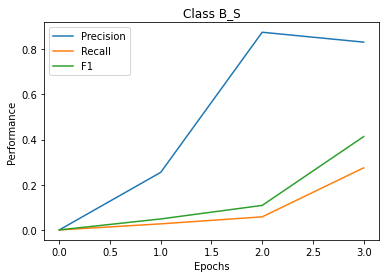

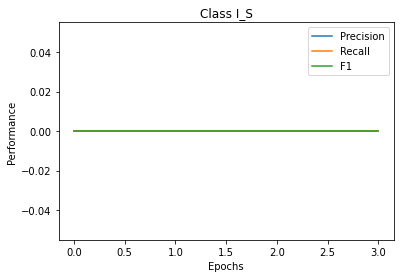

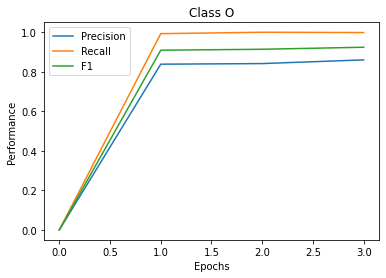

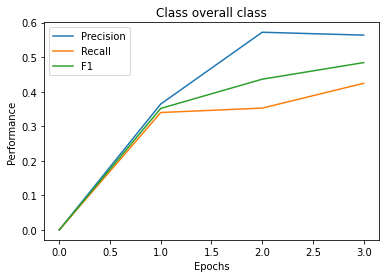

In [12]:
performance.evalModelTrainDataClass()

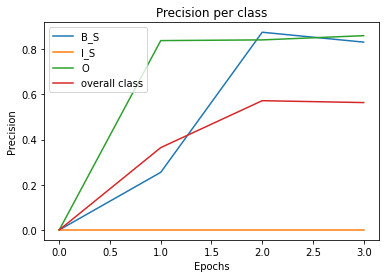

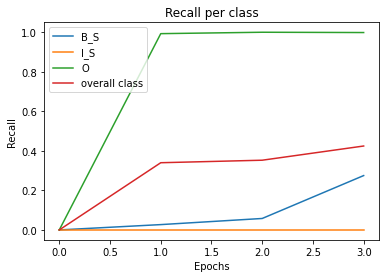

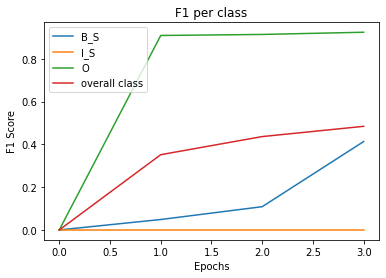

In [13]:
performance.evalModelTrainData()

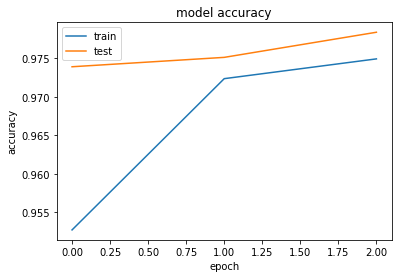

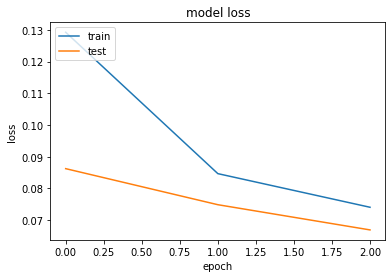

In [14]:
performance.basicEval(history)

In [15]:
performance.classicEval(model, ds,vw,x_test,y_test)

,B_S_pred,I_S_pred,O_pred
B_S_true,133.0,0.0,351.0
I_S_true,18.0,0.0,403.0
O_true,9.0,0.0,4625.0


class: B_S
precision: 0.831
recall: 0.275
f1 0.413
no (None / NULL) precision or recall for class I_S
class: O
precision: 0.860
recall: 0.998
f1 0.924

Precision 0.564
Recall 0.424
F1-measure 0.484


### with 100 units 


### with 200 units
class: B_S
precision: 0.743
recall: 0.477
f1 0.581
class: I_S
precision: 0.625
recall: 0.012
f1 0.023
class: O
precision: 0.880
recall: 0.992
f1 0.933

Precision 0.749
Recall 0.494
F1-measure 0.595